In [60]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
adata = sc.read_10x_mtx('hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols (stored within the .mtx file along w/ the UMIs) for the variable names (variables-axis index)
    
    cache=True) 

adata.var_names_make_unique()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [62]:
adata.shape
# 2700 cells, 32738 genes

(2700, 32738)

In [63]:
# proprocessing: filter out genes expressed in less than 3 cells and cells expressing less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [64]:
# 13708 features (genes) left, 2700 cells left
adata.shape

(2700, 13714)

In [65]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_ol

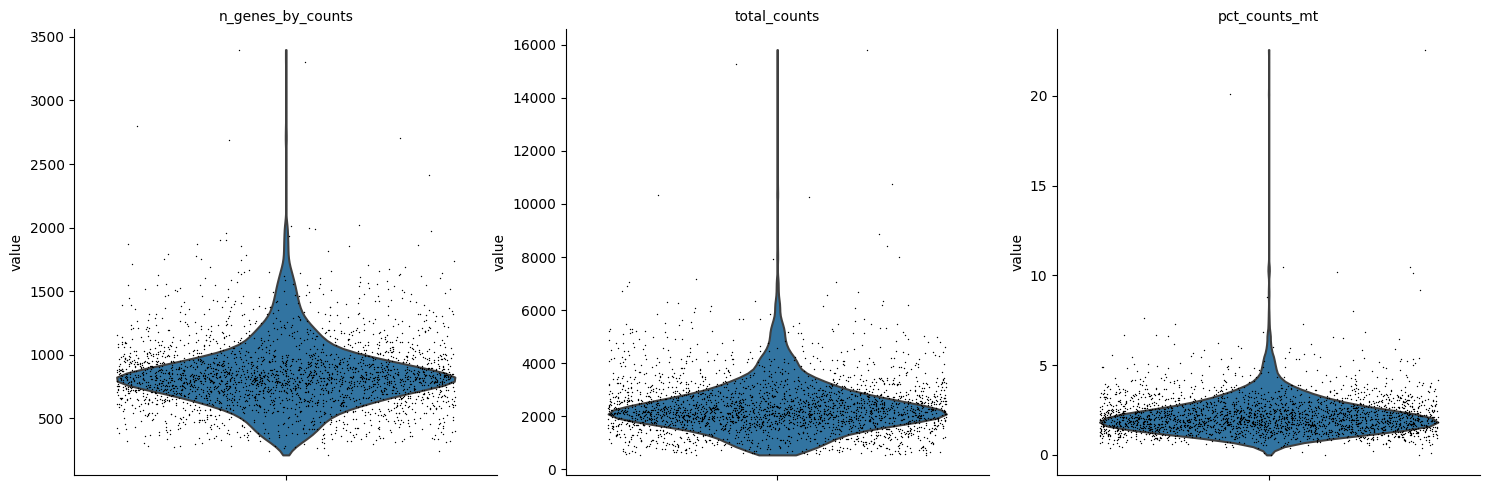

In [66]:
#a violin plot of the qc metrics
#n_genes_by_counts: Number of genes for which the counts are nonzero
#total_counts: Total counts for this cell
#pct_counts_mt: Fraction of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [67]:
#mitochondrial genes are expressed at higher levels in apoptotic, dying cells
#too many genes expressed: possible multiplets
#too few genes expressed: possible dead, low quality cells
print(f'Before filtering: {adata.X.shape}')

adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :]
print(f'After filtering: {adata.X.shape}')

Before filtering: (2700, 13714)
After filtering: (2638, 13714)


In [68]:
adata.X = sc.pp.normalize_total(adata, inplace=False, target_sum=10000)["X"]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [69]:
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000) 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:72: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(


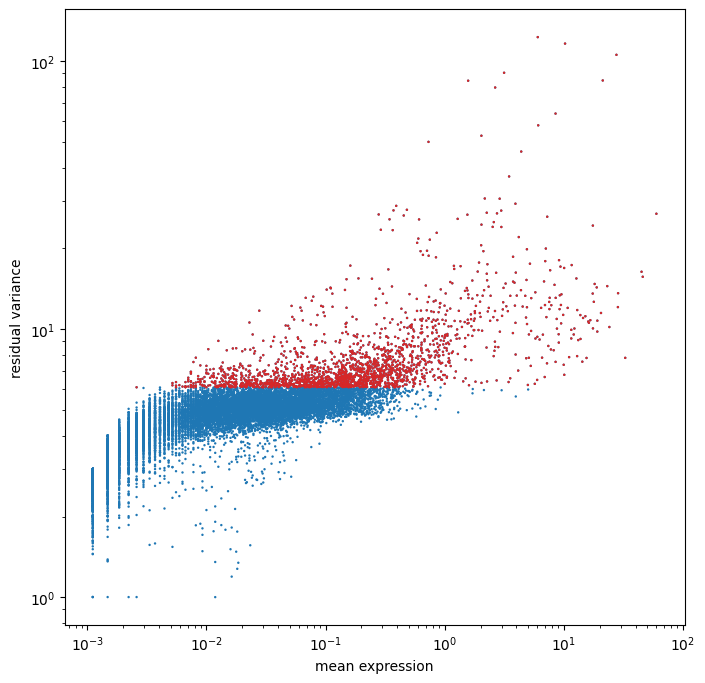

In [70]:
hvgs = adata.var["highly_variable"]

plt.figure(figsize=(8,8))
plt.scatter(adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none")
plt.scatter( 
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("mean expression")
plt.ylabel("residual variance")

plt.show()

In [71]:
sc.pp.scale(adata.X)

array([[-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       ...,
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
         3.6252079e+01, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01]], dtype=float32)

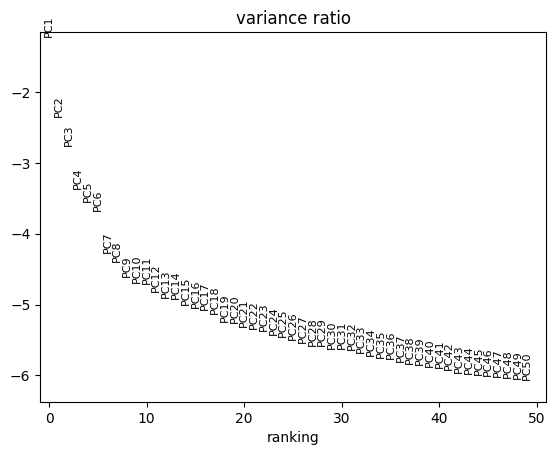

First 50 PCs explain 0.7564138770103455 of variance


In [72]:
X_pca = sc.pp.pca(adata, n_comps=50) 

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) 

print(f"First 50 PCs explain {np.sum(adata.uns['pca']['variance_ratio'][:80])} of variance")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


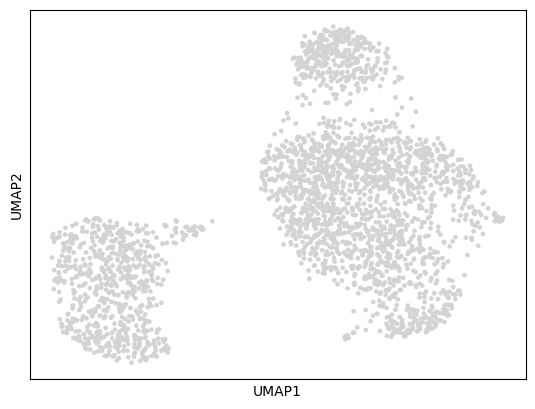

In [73]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

sc.tl.umap(adata)
sc.pl.umap(adata)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


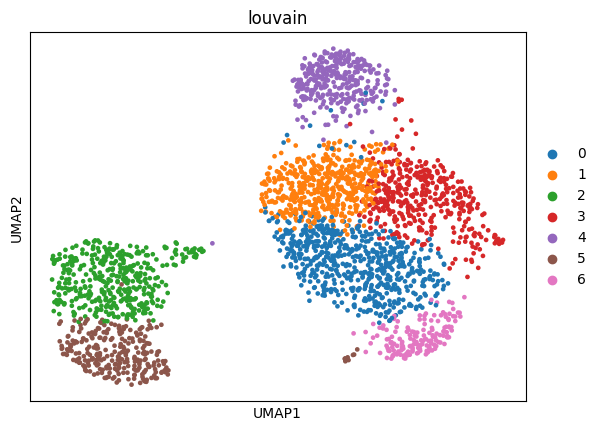

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


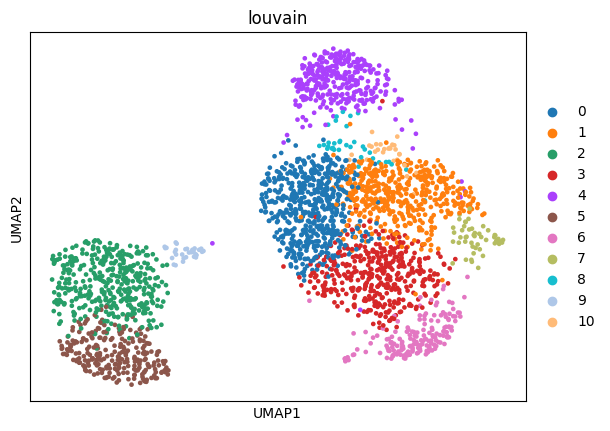

In [74]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)

sc.tl.louvain(adata)

sc.pl.umap(adata, color=["louvain"], cmap="tab20")

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

sc.tl.louvain(adata)

sc.pl.umap(adata, color=["louvain"], cmap="tab20")

#6 clusters w 50 neighbors, 13 clusters w 5 neighbors

In [253]:
import lsh
import kdtree
import knn
import importlib
importlib.reload(kdtree)
importlib.reload(lsh)
importlib.reload(knn)

<module 'knn' from '/Users/koheisanno/Documents/School/COS521_Final/knn.py'>

In [251]:
pca_data.shape

(2638, 50)

In [242]:
pca_data = adata.obsm['X_pca']

In [254]:
knn_lsh = knn.KNN_LSH(pca_data.shape[1], 7, 280, 700, similarity_metric='jaccard')
knn_lsh.construct_knng(pca_data, 15)

constructing data structure
iteration  0
iteration  50
iteration  100
iteration  150
iteration  200
iteration  250
iteration  300
iteration  350
iteration  400
iteration  450
iteration  500
iteration  550
iteration  600
iteration  650
iteration  700
iteration  750
iteration  800
iteration  850
iteration  900
iteration  950
iteration  1000
iteration  1050
iteration  1100
iteration  1150
iteration  1200
iteration  1250
iteration  1300
iteration  1350
iteration  1400
iteration  1450
iteration  1500
iteration  1550
iteration  1600
iteration  1650
iteration  1700
iteration  1750
iteration  1800
iteration  1850
iteration  1900
iteration  1950
iteration  2000
iteration  2050
iteration  2100
iteration  2150
iteration  2200
iteration  2250
iteration  2300
iteration  2350
iteration  2400
iteration  2450
iteration  2500
iteration  2550
iteration  2600
querying points...
iteration  0
iteration  2000
computing jaccard similarity...


In [245]:
knn_brute = knn.KNN_Brute(pca_data.shape[1], similarity_metric='jaccard')
knn_brute.construct_knng(pca_data, 15)

In [214]:
knn_kdt = knn.KNN_KDT(pca_data.shape[1], similarity_metric='jaccard')
knn_kdt.construct_knng(pca_data, 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


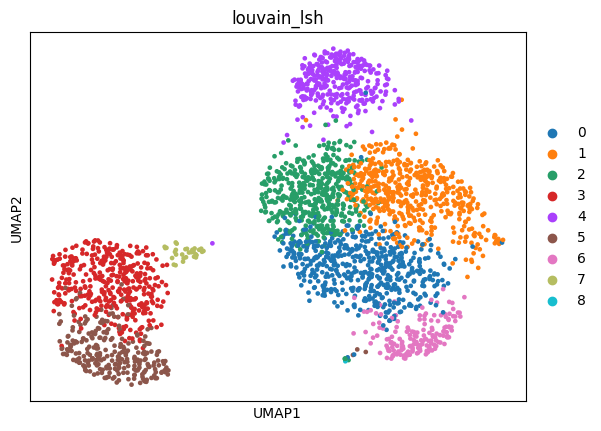

In [246]:
sc.tl.louvain(adata, adjacency=knn_lsh.sp_adj_matrix, key_added="louvain_lsh")

sc.pl.umap(adata, color=["louvain_lsh"], cmap="tab20")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


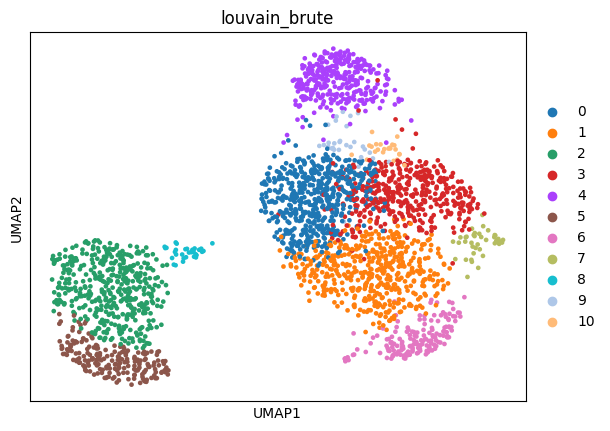

In [223]:
sc.tl.louvain(adata, adjacency=knn_brute.sp_adj_matrix, key_added="louvain_brute")

sc.pl.umap(adata, color=["louvain_brute"], cmap="tab20")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


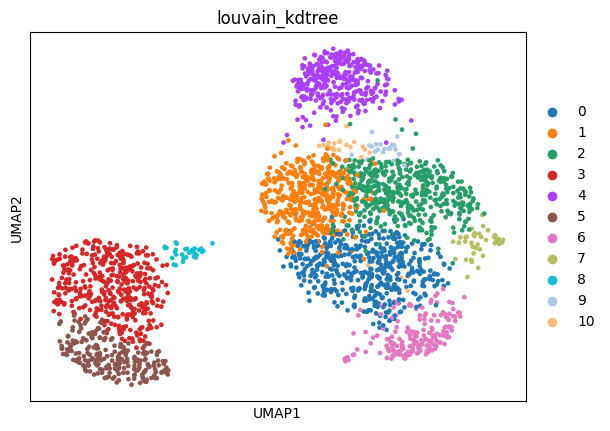

In [218]:
sc.tl.louvain(adata, adjacency=knn_kdt.sp_adj_matrix, key_added="louvain_kdtree")

sc.pl.umap(adata, color=["louvain_kdtree"], cmap="tab20")

In [249]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(adata.obs['louvain_kdtree'], adata.obs['louvain_lsh'])

0.7720319425355872